# DESIGN AND IMPLEMENTATION OF A GPS ASSISTED PRECISION BANANA PLANTING

## Data Loading & Setup

We begin by importing essential Python libraries for data analysis and visualization. This includes:
- `pandas` and `numpy` for data handling and numeric operations.
- `matplotlib` and `seaborn` for plotting.
- Warning suppression is also enabled to keep the output clean.

In [1]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [19]:
# Import core data manipulation libraries
import pandas as pd     # For handling datasets and dataframes
from geopy.distance import geodesic
import numpy as np      # For numerical operations
import folium

# Import visualization libraries
import matplotlib.pyplot as plt      # For basic plotting
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 10, 8   # Set default figure size for plots

import seaborn as sns                # For advanced and attractive data visualizations
sns.set(style='whitegrid')

# Suppress future warnings to keep notebook output clean
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

In [20]:
df = pd.read_excel('data/GPS_Banana_Planting_Dataset.xlsx')

print(df.shape)
df.head()

(100, 13)


,Plant_ID,GPS_Latitude,GPS_Longitude,Planting_Date,Plant_Variety,Soil_Moisture_Level,Plant_Depth_cm,Expected_Depth_cm,Growth_Status,Anomaly_Flag,Anomaly_Type,Captured_By,Timestamp
0,BN001,7.502789,4.490500,2025-06-02,Plantain,23.4,34.7,30,Stunted,False,NaN,Worker5,2025-06-02 13:10:07
1,BN002,7.491739,4.498438,2025-06-12,Cavendish,23.1,30.1,30,Healthy,False,NaN,Worker5,2025-06-12 13:10:07
2,BN003,7.493977,4.502998,2025-05-22,Red Banana,23.2,31.8,30,Healthy,False,NaN,Worker2,2025-05-22 13:10:07
3,BN004,7.503963,4.496805,2025-06-04,Cavendish,67.4,26.7,30,Healthy,False,NaN,Worker4,2025-06-04 13:10:07
4,BN005,7.491934,4.506950,2025-06-01,Red Banana,58.4,34.6,30,Stunted,False,NaN,Worker1,2025-06-01 13:10:07


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Plant_ID             100 non-null    object        
 1   GPS_Latitude         100 non-null    float64       
 2   GPS_Longitude        100 non-null    float64       
 3   Planting_Date        100 non-null    datetime64[ns]
 4   Plant_Variety        100 non-null    object        
 5   Soil_Moisture_Level  100 non-null    float64       
 6   Plant_Depth_cm       100 non-null    float64       
 7   Expected_Depth_cm    100 non-null    int64         
 8   Growth_Status        100 non-null    object        
 9   Anomaly_Flag         100 non-null    bool          
 10  Anomaly_Type         62 non-null     object        
 11  Captured_By          100 non-null    object        
 12  Timestamp            100 non-null    object        
dtypes: bool(1), datetime64[ns](1), float

In [22]:
df = df.query('Plant_Variety != "Red Banana"')

In [23]:
lat_min, lat_max = df['GPS_Latitude'].min(), df['GPS_Latitude'].max()
df['norm_lat'] = (df['GPS_Latitude'] - lat_min) / (lat_max - lat_min)

long_min, long_max = df['GPS_Longitude'].min(), df['GPS_Longitude'].max()
df['norm_long'] = (df['GPS_Longitude'] - long_min) / (long_max - long_min)

campus_lat = 7.74382405720694
campus_long = 4.5460465397247285

lat_range = 0.0004
long_range = 0.0004

df['GPS_Latitude'] = campus_lat - (lat_range / 2) + df['norm_lat'] * lat_range
df['GPS_Longitude'] = campus_long - (long_range / 2) + df['norm_long'] * long_range

In [24]:
# Define a function to compute distance to the closest other plant
def compute_nearest_spacing(row, df):
    current_point = (row['GPS_Latitude'], row['GPS_Longitude'])
    
    # Exclude the current row and compute distance to all others
    other_points = df.loc[df.index != row.name, ['GPS_Latitude', 'GPS_Longitude']].values
    distances = [geodesic(current_point, (lat, lon)).meters for lat, lon in other_points]
    
    return np.min(distances) if distances else np.nan

# Apply to DataFrame to create a new column 'Spacing_m'
df['Spacing_m'] = df.apply(lambda row: compute_nearest_spacing(row, df), axis=1)

df.head(5)

,Plant_ID,GPS_Latitude,GPS_Longitude,Planting_Date,Plant_Variety,Soil_Moisture_Level,Plant_Depth_cm,Expected_Depth_cm,Growth_Status,Anomaly_Flag,Anomaly_Type,Captured_By,Timestamp,norm_lat,norm_long,Spacing_m
0,BN001,7.743884,4.545855,2025-06-02,Plantain,23.4,34.7,30,Stunted,False,NaN,Worker5,2025-06-02 13:10:07,0.650062,0.020593,1.180417
1,BN002,7.743657,4.546023,2025-06-12,Cavendish,23.1,30.1,30,Healthy,False,NaN,Worker5,2025-06-12 13:10:07,0.083162,0.440815,2.161648
3,BN004,7.743908,4.545988,2025-06-04,Cavendish,67.4,26.7,30,Healthy,False,NaN,Worker4,2025-06-04 13:10:07,0.710291,0.354367,1.772799
7,BN008,7.743778,4.546036,2025-06-07,Plantain,32.2,24.2,30,Wilting,True,Shallow depth,Worker1,2025-06-07 13:10:07,0.384004,0.474166,3.989289
9,BN010,7.743712,4.545982,2025-06-03,Cavendish,59.3,36.1,30,Wilting,True,Over-depth,Worker3,2025-06-03 13:10:07,0.219269,0.337480,3.211524


In [25]:
# Define a function to categorize spacing into discrete groups
def space_range(spacing):
    if spacing < 2:
        return 'Below 2m'
    elif 2 <= spacing <= 4:
        return '2-4m'
    else:
        return 'Above 4m'

# Apply the function to create a new AGE_GROUP column
df['Space_Range'] = df['Spacing_m'].apply(space_range)
df['Space_Range'].value_counts()

Space_Range
Below 2m    30
2-4m        24
Above 4m    17
Name: count, dtype: int64

In [26]:
df.drop(columns=['norm_lat', 'norm_long', 'Planting_Date', 'Captured_By', 'Timestamp', 'Soil_Moisture_Level', 'Plant_Depth_cm', 'Expected_Depth_cm', 'Anomaly_Flag', 'Anomaly_Type'], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71 entries, 0 to 98
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Plant_ID       71 non-null     object 
 1   GPS_Latitude   71 non-null     float64
 2   GPS_Longitude  71 non-null     float64
 3   Plant_Variety  71 non-null     object 
 4   Growth_Status  71 non-null     object 
 5   Spacing_m      71 non-null     float64
 6   Space_Range    71 non-null     object 
dtypes: float64(3), object(4)
memory usage: 4.4+ KB


In [27]:
df.head(5)

,Plant_ID,GPS_Latitude,GPS_Longitude,Plant_Variety,Growth_Status,Spacing_m,Space_Range
0,BN001,7.743884,4.545855,Plantain,Stunted,1.180417,Below 2m
1,BN002,7.743657,4.546023,Cavendish,Healthy,2.161648,2-4m
3,BN004,7.743908,4.545988,Cavendish,Healthy,1.772799,Below 2m
7,BN008,7.743778,4.546036,Plantain,Wilting,3.989289,2-4m
9,BN010,7.743712,4.545982,Cavendish,Wilting,3.211524,2-4m


In [28]:
df.to_csv("data/cleaned_banana_data.csv", index=False)

## Exploratory Data Analysis

### Descriptive Summary

In [29]:
def add_percentage_labels(ax, total):
    for p in ax.patches:
        percentage = 100 * p.get_height() / total
        ax.annotate(f'{percentage:.1f}%',
                    (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom')

Plantain: 53.5%
Cavendish: 46.5%


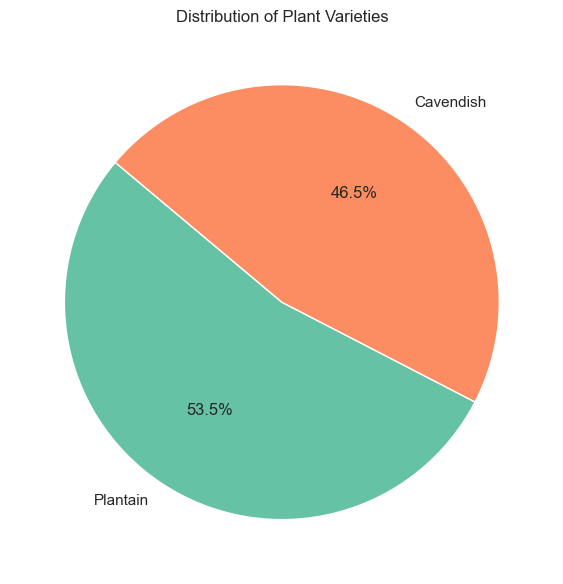

Stunted: 33.8%
Healthy: 33.8%
Wilting: 32.4%


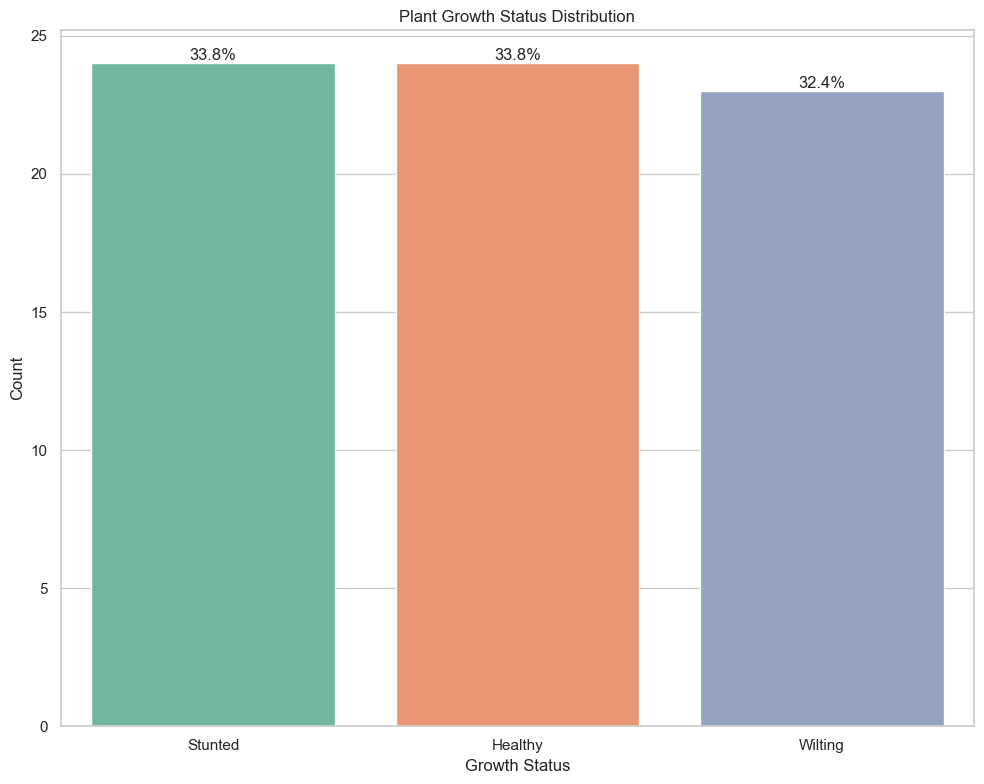


Growth Status by Plant Variety - Percentage (%):
 Growth_Status  Healthy  Stunted  Wilting
Plant_Variety                           
Cavendish        45.45    27.27    27.27
Plantain         23.68    39.47    36.84


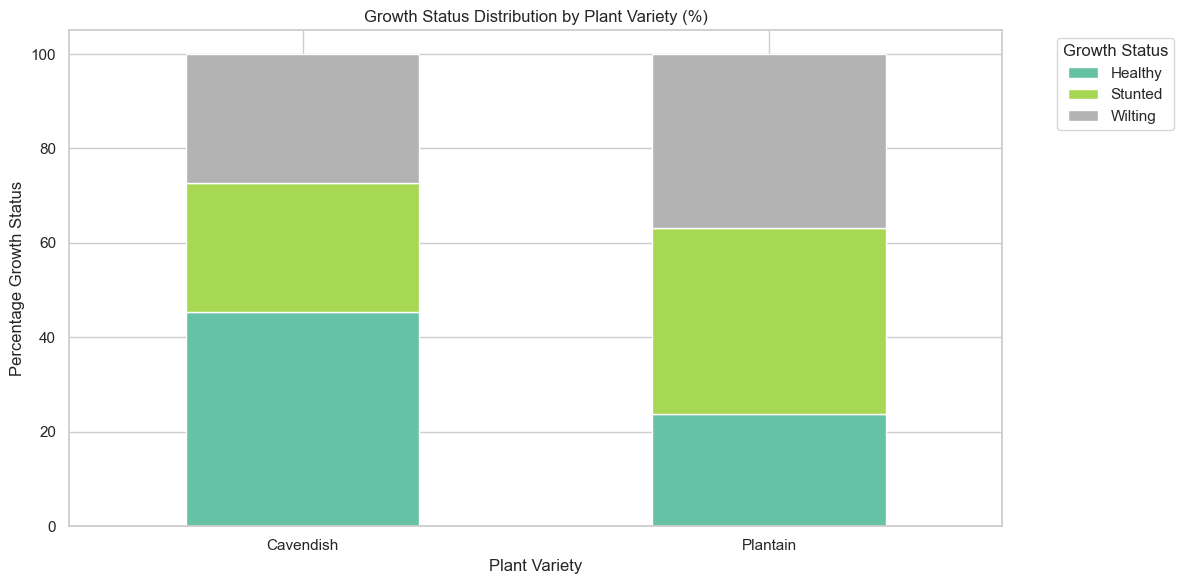

Below 2m: 42.3%
2-4m: 33.8%
Above 4m: 23.9%


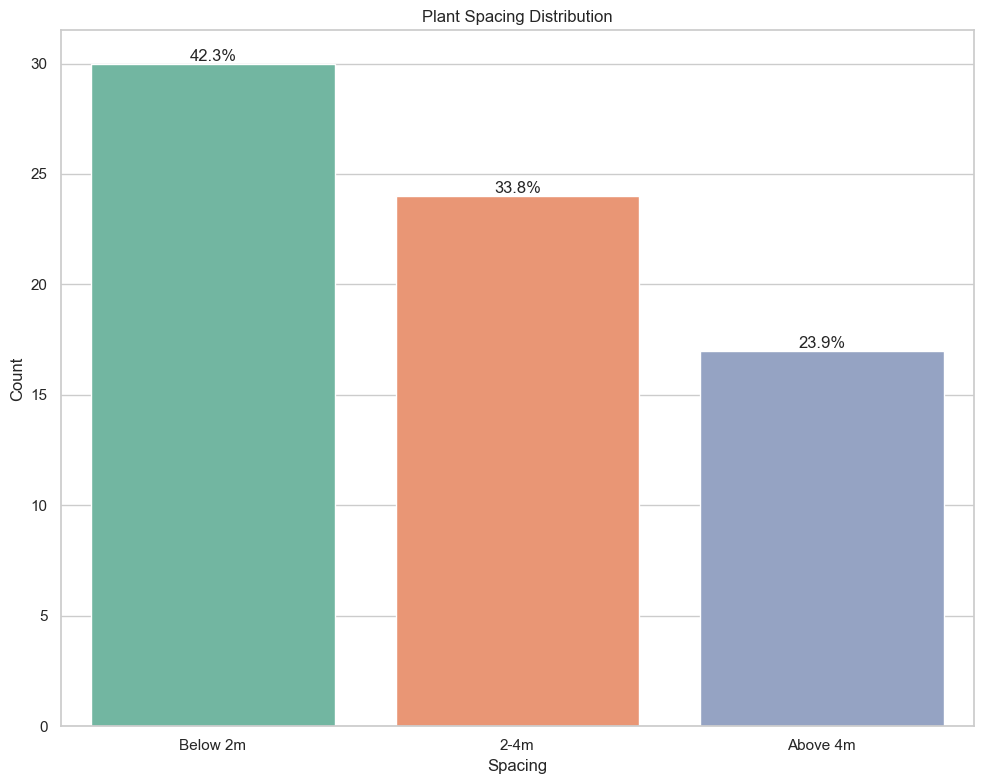

In [30]:
# 1. Count by Plant Variety

variety_count = df['Plant_Variety'].value_counts()
colors = sns.color_palette('Set2')[:len(variety_count)]

total = variety_count.sum()
percentages = (variety_count / total * 100).round(1)
    
# Display table of percentages
for response, pct in percentages.items():
    print(f"{response}: {pct}%")

plt.figure(figsize=(6,6))
plt.pie(variety_count, labels=variety_count.index, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title('Distribution of Plant Varieties')
plt.tight_layout()
plt.show()

# 2. Count by Growth Status

growth_count = df['Growth_Status'].value_counts()
colors = sns.color_palette('Set2')[:len(growth_count)]

total = growth_count.sum()
percentages = (growth_count / total * 100).round(1)
    
# Display table of percentages
for response, pct in percentages.items():
    print(f"{response}: {pct}%")

ax = sns.barplot(x=growth_count.index, y=growth_count.values, palette='Set2')
add_percentage_labels(ax, growth_count.sum())
plt.title('Plant Growth Status Distribution')
plt.ylabel('Count')
plt.xlabel('Growth Status')
plt.tight_layout()
plt.show()

# 3. Crosstab: Growth Status vs Plant Variety

ct = pd.crosstab(df['Plant_Variety'], df['Growth_Status'], normalize='index') * 100

print("\nGrowth Status by Plant Variety - Percentage (%):\n", ct.round(2))

# Plot stacked bar chart for Degree_Class by Age_Group (percentage)
ct.plot(kind='bar', stacked=True, figsize=(12,6), colormap='Set2')
plt.title('Growth Status Distribution by Plant Variety (%)')
plt.ylabel('Percentage Growth Status')
plt.xlabel('Plant Variety')
plt.xticks(rotation=0)
plt.legend(title='Growth Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 4. Count by Spacing Range

spacing_count = df['Space_Range'].value_counts()
colors = sns.color_palette('Set2')[:len(spacing_count)]

total = spacing_count.sum()
percentages = (spacing_count / total * 100).round(1)
    
# Display table of percentages
for response, pct in percentages.items():
    print(f"{response}: {pct}%")

ax = sns.barplot(x=spacing_count.index, y=spacing_count.values, palette='Set2')
add_percentage_labels(ax, spacing_count.sum())
plt.title('Plant Spacing Distribution')
plt.ylabel('Count')
plt.xlabel('Spacing')
plt.tight_layout()
plt.show()

### Spacing Analysis

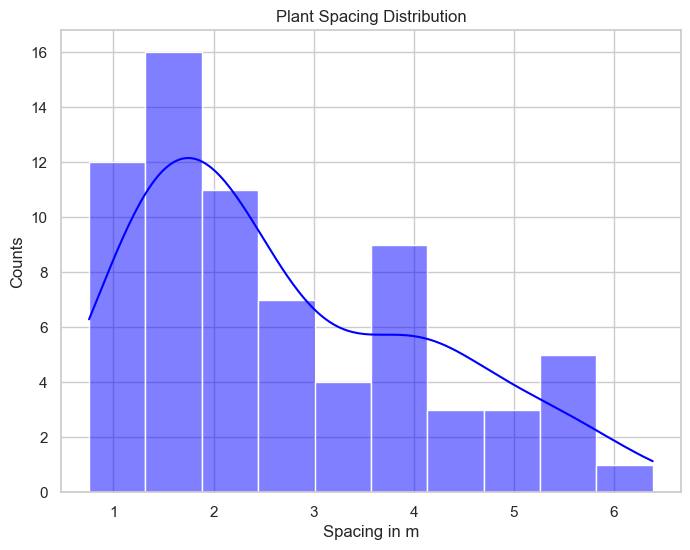

Growth Status Summary by Spacing (Boxplot Quartiles):

               25% (Q1)  50% (Median)  75% (Q3)
Growth_Status                                  
Healthy            1.75          3.08      4.24
Stunted            1.35          2.20      3.00
Wilting            1.66          2.10      3.20


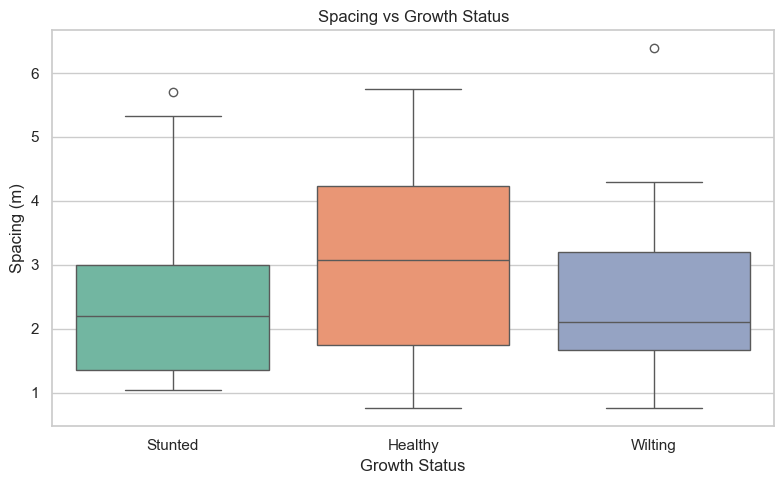


Growth Status by Spacing Range - Percentage (%):
 Space_Range     2-4m  Above 4m  Below 2m
Growth_Status                           
Healthy        16.67     45.83     37.50
Stunted        37.50     16.67     45.83
Wilting        47.83      8.70     43.48


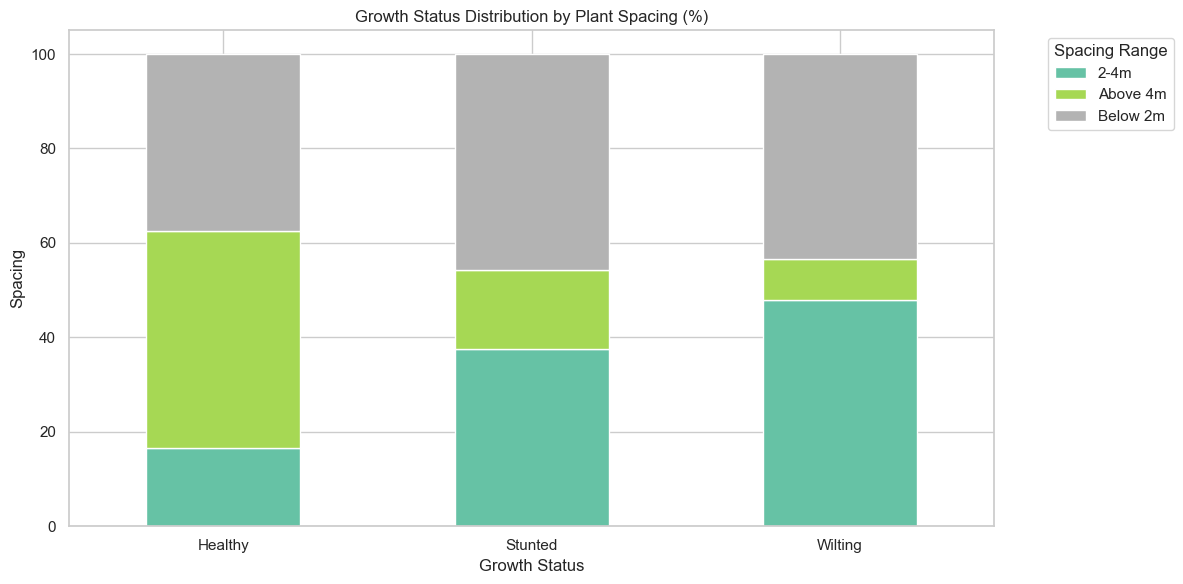

In [31]:
# 1. Plant Spacing Distribution

plt.figure(figsize=(8, 6))
ax = sns.histplot(data=df, x='Spacing_m', kde=True, bins=10, color='blue')

plt.title('Plant Spacing Distribution')
plt.xlabel('Spacing in m')
plt.ylabel('Counts')
plt.show()

# 2. Spacing by Growth Status

# Calculate Q1, Median (Q2), Q3 for each Growth Status
summary_stats = df.groupby('Growth_Status')['Spacing_m'].quantile([0.25, 0.5, 0.75]).unstack()

# Rename columns for clarity
summary_stats.columns = ['25% (Q1)', '50% (Median)', '75% (Q3)']
summary_stats = summary_stats.round(2)

# Print the summary stats
print("Growth Status Summary by Spacing (Boxplot Quartiles):\n")
print(summary_stats)

plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='Growth_Status', y='Spacing_m', palette='Set2')
plt.title("Spacing vs Growth Status")
plt.xlabel("Growth Status")
plt.ylabel("Spacing (m)")
plt.tight_layout()
plt.show()

# 3. Crosstab of Growth Status by Spacing Category

ct = pd.crosstab(df['Growth_Status'], df['Space_Range'], normalize='index') * 100

print("\nGrowth Status by Spacing Range - Percentage (%):\n", ct.round(2))

# Plot stacked bar chart for Degree_Class by Age_Group (percentage)
ct.plot(kind='bar', stacked=True, figsize=(12,6), colormap='Set2')
plt.title('Growth Status Distribution by Plant Spacing (%)')
plt.ylabel('Spacing')
plt.xlabel('Growth Status')
plt.xticks(rotation=0)
plt.legend(title='Spacing Range', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Plant variety & Growth Relationship


Growth Status by Plant Variety - Percentage (%):
 Growth_Status  Healthy  Stunted  Wilting
Plant_Variety                           
Cavendish        45.45    27.27    27.27
Plantain         23.68    39.47    36.84


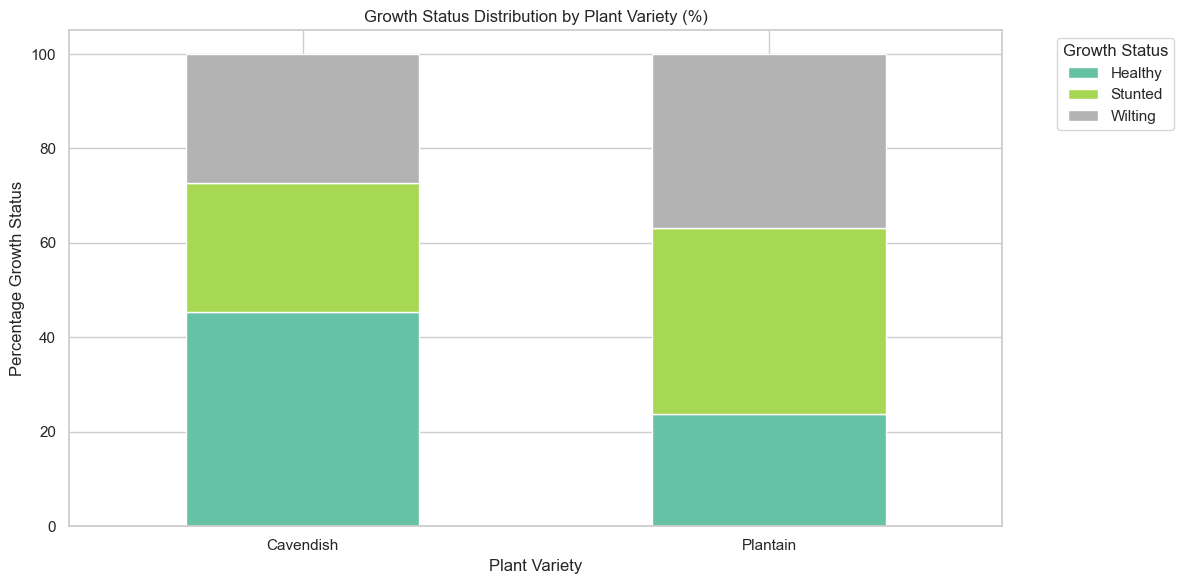

Stunted: 39.5%
Wilting: 36.8%
Healthy: 23.7%


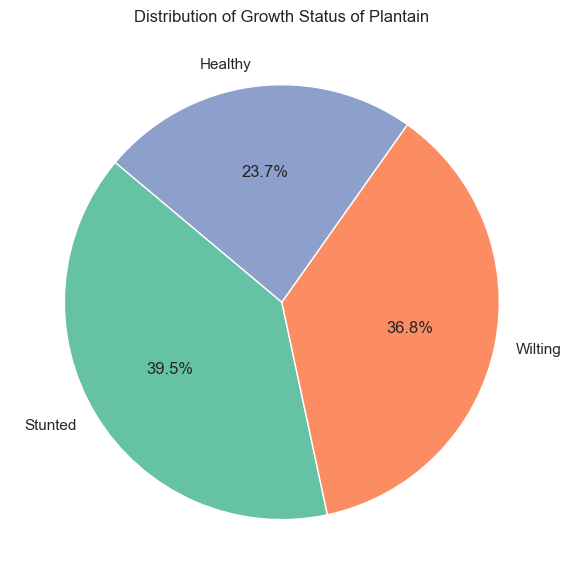

Healthy: 45.5%
Wilting: 27.3%
Stunted: 27.3%


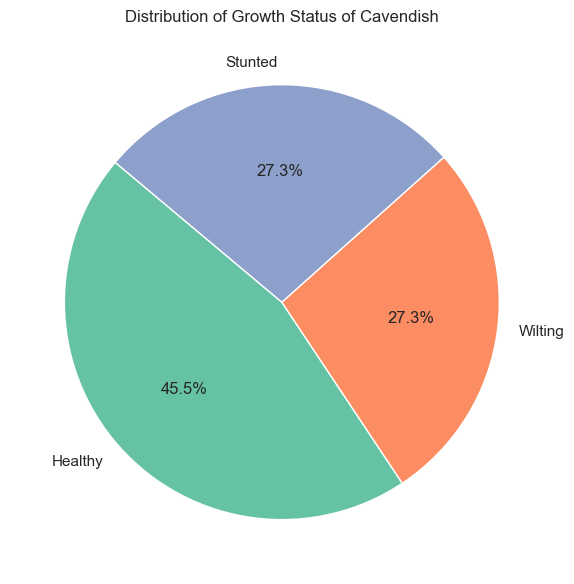

In [32]:
# 1. Crosstab: Growth Status vs Plant Variety

ct = pd.crosstab(df['Plant_Variety'], df['Growth_Status'], normalize='index') * 100

print("\nGrowth Status by Plant Variety - Percentage (%):\n", ct.round(2))

# Plot stacked bar chart for Degree_Class by Age_Group (percentage)
ct.plot(kind='bar', stacked=True, figsize=(12,6), colormap='Set2')
plt.title('Growth Status Distribution by Plant Variety (%)')
plt.ylabel('Percentage Growth Status')
plt.xlabel('Plant Variety')
plt.xticks(rotation=0)
plt.legend(title='Growth Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 2. % Growth Status per Variety

just_plantain = df.query('Plant_Variety == "Plantain"')

status_count = just_plantain['Growth_Status'].value_counts()
colors = sns.color_palette('Set2')[:len(status_count)]

total = status_count.sum()
percentages = (status_count / total * 100).round(1)
    
# Display table of percentages
for response, pct in percentages.items():
    print(f"{response}: {pct}%")

plt.figure(figsize=(6,6))
plt.pie(status_count, labels=status_count.index, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title('Distribution of Growth Status of Plantain')
plt.tight_layout()
plt.show()

just_plantain = df.query('Plant_Variety == "Cavendish"')

status_count = just_plantain['Growth_Status'].value_counts()
colors = sns.color_palette('Set2')[:len(status_count)]

total = status_count.sum()
percentages = (status_count / total * 100).round(1)
    
# Display table of percentages
for response, pct in percentages.items():
    print(f"{response}: {pct}%")

plt.figure(figsize=(6,6))
plt.pie(status_count, labels=status_count.index, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title('Distribution of Growth Status of Cavendish')
plt.tight_layout()
plt.show()

# Exploratory Data Analysis Summary

## Data Preprocessing

- Loaded the raw dataset and inspected initial structure
- Calculated plant-to-nearest-plant spacing (in meters) using **Geopy** with GPS coordinates
- Created a new column: **`Spacing_m`**
- Categorized spacing into 3 bins:
  - **Below 2m**
  - **2–4m**
  - **Above 4m**
- Verified and standardized all rows
- Saved cleaned dataset as: `cleaned_banana_data.csv`


## Exploratory Data Analysis (EDA)

### Plant Variety Distribution
- **Plantain**: 53.5%  
- **Cavendish**: 46.5%  

### Plant Growth Status Distribution
- **Stunted**: 33.8%  
- **Healthy**: 33.8%  
- **Wilting**: 32.4%  

### Growth Status by Plant Variety (%)

| Plant Variety | Healthy | Stunted | Wilting |
|---------------|---------|---------|---------|
| **Cavendish** | 45.5%   | 27.3%   | 27.3%   |
| **Plantain**  | 23.7%   | 39.5%   | 36.8%   |

### Spacing Distribution

- **Below 2m**: 42.3%  
- **2–4m**: 33.8%  
- **Above 4m**: 23.9%  

**Spacing Histogram**: Left-skewed — majority of plants are closely spaced

### Spacing vs Growth Status (Boxplot)

| Growth Status | Q1 (25%) | Median (50%) | Q3 (75%) |
|---------------|----------|--------------|----------|
| **Healthy**   | 1.75 m   | 3.08 m       | 4.24 m   |
| **Stunted**   | 1.35 m   | 2.20 m       | 3.00 m   |
| **Wilting**   | 1.66 m   | 2.10 m       | 3.20 m   |

> **Insight**: Healthy plants tend to have more optimal spacing than stunted or wilting ones.

### Growth Status by Spacing Range (%)

| Spacing Range | Healthy | Stunted | Wilting |
|---------------|---------|---------|---------|
| **Below 2m**  | 37.5%   | 45.8%   | 43.5%   |
| **2–4m**      | 16.7%   | 37.5%   | 47.8%   |
| **Above 4m**  | 45.8%   | 16.7%   | 8.7%    |

> **Observation**: Wider spacing (Above 4m) is associated with better plant health.

### Growth Status Within Each Variety

#### **Plantain**  
- **Stunted**: 39.5%  
- **Wilting**: 36.8%  
- **Healthy**: 23.7%  

#### **Cavendish**  
- **Healthy**: 45.5%  
- **Wilting**: 27.3%  
- **Stunted**: 27.3%  

> **Conclusion**: Cavendish outperformed Plantain in terms of plant health.

## Spatial Visualization

In [33]:
# Average location to center the map
map_center = [df['GPS_Latitude'].mean(), df['GPS_Longitude'].mean()]

# Base map
all_map = folium.Map(location=map_center, zoom_start=17)

# Add all planting points
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['GPS_Latitude'], row['GPS_Longitude']],
        radius=2,
        color='blue',
        fill=True,
        fill_opacity=0.6
    ).add_to(all_map)

# Save map
all_map.save("All_Planting_Points_Map.html")

In [34]:
color_dict = {
    'Wilting': 'red',
    'Stunted': 'orange',
    'Healthy': 'green'
}

In [35]:
all_plant_map = folium.Map(location=map_center, zoom_start=17)

for _, row in df.iterrows():
    status = str(row['Growth_Status']).strip().title()
    color = color_dict.get(status, 'gray')
    
    folium.CircleMarker(
        location=[row['GPS_Latitude'], row['GPS_Longitude']],
        radius=3,  # smaller than default marker
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.9,
        popup=folium.Popup(
            f"<b>Variety:</b> {row['Plant_Variety']}<br>"
            f"<b>Spacing:</b> {row['Spacing_m']:.2f} m<br>"
            f"<b>Growth Status:</b> {row['Growth_Status']}<br>"
            f"<b>Latitude:</b> {row['GPS_Latitude']}<br>"
            f"<b>Longitude:</b> {row['GPS_Longitude']}<br>"
        )
    ).add_to(all_plant_map)

all_plant_map.save("All_Plant_Map.html")

## Spatial Visualization

- Generated an interactive map using **Folium**
- Each plant represented by a marker with:
  - Color indicating **Growth Status**
    - Green → Healthy  
    - Orange → Stunted  
    - Red → Wilting  
  - Popup info:
    - Plant Variety  
    - Spacing (in meters)  
    - Growth Status  
    - Latitude & Longitude  

> **Key Insight**: Visual clustering of stunted/wilting plants may suggest location-specific issues (e.g., soil, compaction, shade).

In [36]:
print('\n\n\n\n\n')

# Analytical Summary: GPS-Assisted Precision Banana Planting

---

## Project Intentions

This project aims to explore how **plant spacing**, **plant variety**, and **growth status** interact within a banana plantation setting, using GPS-coordinated data to identify patterns that may influence plant health and yield. The goals are to:

1. Evaluate the relationship between plant **spacing** and **growth outcomes**
2. Assess how different **banana varieties** perform in the field
3. Use **spatial data** to visualize field layout and uncover location-specific issues
4. Derive practical recommendations for improved precision planting

---

## Data Preprocessing Overview

- Calculated **Spacing** between each plant and its nearest neighbor using the **Geopy** library
- Created a `Spacing_m` column (in meters) to capture this value
- Grouped spacing into three categories:
  - **Below 2m**
  - **2–4m**
  - **Above 4m**
- Verified data consistency and saved a cleaned version as `cleaned_banana_data.csv`

---

## Exploratory Data Analysis (EDA)

### Plant Variety Distribution
- **Plantain**: 53.5%  
- **Cavendish**: 46.5%  
→ *Relatively balanced representation between the two varieties*

---

### Plant Growth Status Distribution
- **Stunted**: 33.8%  
- **Healthy**: 33.8%  
- **Wilting**: 32.4%  
→ *Nearly even distribution across all health statuses, with a slight lean toward poor performance (Wilting + Stunted = 66.2%)*

---

### Variety vs Growth Status (%)

| Variety     | Healthy | Stunted | Wilting |
|-------------|---------|---------|---------|
| Cavendish   | 45.5%   | 27.3%   | 27.3%   |
| Plantain    | 23.7%   | 39.5%   | 36.8%   |

> **Insight**: Cavendish plants were significantly more likely to be healthy, while Plantain had more cases of stunted and wilting growth.

---

### Spacing Distribution
- **Below 2m**: 42.3%  
- **2–4m**: 33.8%  
- **Above 4m**: 23.9%  
→ *Majority of plants were spaced too closely (Below 2m)*

**Spacing Histogram**: Left-skewed — indicates a tendency toward tight spacing

---

### Spacing vs Growth Status (Boxplot)

| Growth Status | Q1 (25%) | Median (50%) | Q3 (75%) |
|---------------|----------|--------------|----------|
| Healthy       | 1.75 m   | 3.08 m       | 4.24 m   |
| Stunted       | 1.35 m   | 2.20 m       | 3.00 m   |
| Wilting       | 1.66 m   | 2.10 m       | 3.20 m   |

> **Insight**: Healthy plants generally have **wider spacing** than Stunted or Wilting ones.

---

### Growth Status by Spacing Range (%)

| Spacing Range | Healthy | Stunted | Wilting |
|---------------|---------|---------|---------|
| Below 2m      | 37.5%   | 45.8%   | 43.5%   |
| 2–4m          | 16.7%   | 37.5%   | 47.8%   |
| Above 4m      | 45.8%   | 16.7%   | 8.7%    |

> **Insight**: 
- Plants spaced **Above 4m** show the **highest proportion of healthy growth**  
- Plants spaced **Below 2m** had the **highest stunting and wilting rates**

---

### Individual Variety Breakdown

#### Plantain
- **Stunted**: 39.5%  
- **Wilting**: 36.8%  
- **Healthy**: 23.7%  

#### Cavendish
- **Healthy**: 45.5%  
- **Wilting**: 27.3%  
- **Stunted**: 27.3%

> **Observation**: Cavendish plants clearly outperform Plantain in this field setting.

---

## Spatial Visualization

- Created an **interactive map** using `Folium` with each plant represented by a color-coded marker:
  - Healthy → Green  
  - Stunted → Orange  
  - Wilting → Red
- Marker popups display:
  - Plant Variety  
  - Spacing  
  - Growth Status  
  - GPS Coordinates

> **Visual Insight**: The map reveals **clusters** of unhealthy plants, particularly in tightly spaced regions, supporting findings from EDA.

---

## Key Conclusions

- **Closer spacing** (< 2m) is strongly associated with **stunted and wilting** plants
- **Cavendish variety** outperforms **Plantain** in terms of health under current conditions
- **Wide spacing (> 4m)** supports healthier plant growth, though only ~24% of plants met this standard
- GPS-enabled analysis provides actionable spatial insight — supporting the value of **precision banana planting**

---

## Outcomes

- Analysis confirms the **need for optimal spacing** (likely ~3–4m) to improve plant performance
- Demonstrated that **variety selection matters**, with Cavendish showing better outcomes
- Validated the effectiveness of **GPS-assisted planting** for monitoring and optimization
- Provides clear direction for **future planting practices** and potential agronomic adjustments

---